In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm 
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\Google Drive\Masterarbeit\Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Navigation

[1 Prep](#1-Prep)
 - [1.1data_raw from csv](#1.1-data_raw-from-csv)
     - [1.1.2 Clean data_raw](#1.2-Clean-data_raw)
     - [1.1.3 Build datasets from data_raw](#1.3-Build-datasets-from-data_raw)
 - [1.2 data_et](#1.2-data_et)
     - [data_et_fixTask](#data_et_fixTask)
     - [data_et_choice](#data_et_choice)
 - [data_trial](#data_trial)
     - [data_trial_fixTask](#data_trial_fixTask)
     - [data_trial_choice](#data_trial_choice)
 - [1.3.3 data_subject](#1.3.3-data_subject)

[2 Prescreeing](#2-Prescreeing)

[3 Analysis](#3-Analysis)
 - [3.1 Does the fps vary across subjects?](#3.1-Does-the-fps-vary-across-subjects?)
 - [3.2 Does the accuracy improve during calibration?](#3.2-Does-the-accuracy-improve-during-calibration?)
 - [3.3 How does the accuracy and precision look like between the fixation tasks?](#3.3-How-does-the-accuracy-and-precision-look-like-between-the-fixation-tasks?)
 - [3.4 Can we predict choice task by how often the people look top](#3.4-Can-we-predict-choice-task-by-how-often-the-people-look-top)

[4 Hypotheses](#4-Hypotheses)

# 1 Prep

 - **1.1 data_raw**
 - **1.2 data_et:** data units vary across eyetracking time points (within eyetracking trials)
 - **1.3 data_trials:** data units vary across trials
 - **1.4 data_subject:** data units vary across subjecs

## 1.1 data_raw

Prep functions

In [4]:
def cleanhtml(raw_html):
    # https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    cleanr = re.compile('<.*?>')
    cleanText = re.sub(cleanr, '', raw_html)
    return cleanText

def cleanSurveyForm(string):
    SurveySection = re.findall(re.compile('{.*?}'), string)
    cleanText = string
    for i in range(0,len(SurveySection)):
        cleanSection = re.sub(",", ";", SurveySection[i])
        cleanText = re.sub(SurveySection[i], cleanSection, cleanText)
    return cleanText

Create Raw-data

In [5]:
subject_files = os.listdir("data")
all_subjects = []
for i in range(0, len(subject_files)):
    rawString = open("data/" + subject_files[i]).read()
    string_noHTML = cleanhtml(rawString)
    string_cleanSurvey = cleanSurveyForm(string_noHTML)
    all_subjects.append(pd.read_csv(StringIO(string_cleanSurvey)))
data_raw = pd.concat(all_subjects).reset_index(drop=True)
# View(data_raw.head(20))

### 1.1.3 Cleaning

Convert to numeric

In [6]:
cols = [
    # Int
    'run_id', 'subject', 'chinFirst', # Subject info
    'trial_index', 'chin', # Trial input
    'key_press',
    'option_topLeft', 'option_bottomLeft', 'option_topRight', 'option_bottomRight', # Eyetracking output
    # Float    
    'task_nr', 'x_pos', 'y_pos', # Trial input
    'rt', 'time_elapsed', 'trial_duration',
    'window_width', 'window_height', 
   
#     'webcam_fps', 'webcam_aspectRatio', 'webcam_height', 'webcam_width', # Webcam
#     't_StartEyeTrackingData', 
    'fps', 'devAvg', 'devPercAvg', # Eyetracking output
    ]
data_raw_num = data_raw
data_raw_num[cols] = data_raw_num[cols].apply(pd.to_numeric, errors='coerce')
# data_raw_num.dtypes

Add window max for each subject

In [7]:
window_per_subject = data_raw_num.groupby(["run_id", "subject"])["window_width", "window_height"].max().reset_index()
window_per_subject.columns = ['run_id', 'subject', 'window_width_max', 'window_height_max']


if np.invert("window_width_max" in data_raw_num.columns):
    data_raw_num = data_raw_num.merge(window_per_subject[["run_id", "subject", "window_width_max"]], 
                            on=['run_id', "subject"])
if np.invert("window_height_max" in data_raw_num.columns):
    data_raw_num = data_raw_num.merge(window_per_subject[["run_id", "subject", "window_height_max"]], 
                            on=['run_id', "subject"])
# data_et.head(5)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [8]:
data_raw = data_raw_num
data_raw.columns

Index(['run_id', 'condition', 'rt', 'stimulus', 'key_press', 'window_width',
       'window_height', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'subject', 'chinFirst', 't_StartEyeTrackingData',
       'webcam_label', 'webcam_Id', 'webcam_fps', 'webcam_aspectRatio',
       'webcam_height', 'webcam_width', 'responses', 'button_pressed', 'chin',
       'success', 'x_pos', 'y_pos', 'task_nr', 'fps', 'devAvg', 'devPercAvg',
       'et_data', 'trial_duration', 'option_topLeft', 'option_bottomLeft',
       'option_topRight', 'option_bottomRight', 'recorded_at', 'ip',
       'user_agent', 'device', 'browser', 'browser_version', 'platform',
       'platform_version', 't_startEyeTrackingData', 'window_width_max',
       'window_height_max'],
      dtype='object')

## 1.2 data_et
[Back to Navigation](#Navigation)

### 1.2.1 extract from data_raw

In [372]:
def extractEyetrackingData(data):
    data_eyetracking = pd.DataFrame(columns=['type', 'index', 'x', 'y', 'px', 'py', 't', 'click']) 
    data["et_data"] = data["et_data"].apply(str)
    for i in range(0, len(data)):
        if ((data.et_data[i] != '"') & (data.et_data[i] != "nan")):
            df = pd.read_csv(StringIO(data.et_data[i]), sep="$") 
            df_noClick = df[(df["click"]==0)].reset_index()
            df["run_id"] = data.run_id[i] # Subject identifier
            df["subject"] = data.subject[i]
            df["chinFirst"] = data.chinFirst[i]
            df["task_nr"] = data.task_nr[i] # Task characteristics
            df['trial_index'] = data.trial_index[i]
            df["chin"] = data.chin[i]
            df["x_pos"] = data.x_pos[i]
            df["y_pos"] = data.y_pos[i]
            df['option_topLeft'] = data.option_topLeft[i]
            df['option_topRight'] = data.option_topRight[i]
            df['option_bottomLeft'] = data.option_bottomLeft[i]
            df['option_bottomRight'] = data.option_bottomRight[i]
            df["tTask"] = (df["t"] - df["t"][0]) # ET-coordinate time variable 
            df["key_press"] = data.key_press[i] # ET-Trial summary data
            df["fps"] = data.fps[i]
            df["devPercAvg"] = data.devPercAvg[i]
            df['rt'] = data.rt[i]
        
            data_eyetracking = data_eyetracking.append(pd.DataFrame(data = df), ignore_index=True)     
    data_eyetracking = data_eyetracking.rename(columns={"type": "trial_type", "tTask": "t_task", "t": "t_wg"})
    data_eyetracking = data_eyetracking[['run_id', 'subject', "chinFirst", # Subject info
                                         'trial_type', 'trial_index', 'index', 'task_nr', 'chin',                                 
                                         'x_pos', 'y_pos', 'px', 'py', # Trial info
                                         'option_topLeft', 'option_topRight', 
                                         'option_bottomLeft', 'option_bottomRight', 
                                         'x', 'y', 't_wg', 't_task', 'rt',
                                         'click', 'key_press', 'fps', 'devPercAvg' # Trial output
                                        ]]
    return(data_eyetracking)

data_et = extractEyetrackingData(data_raw)
data_et.columns

Index(['run_id', 'subject', 'chinFirst', 'trial_type', 'trial_index', 'index',
       'task_nr', 'chin', 'x_pos', 'y_pos', 'px', 'py', 'option_topLeft',
       'option_topRight', 'option_bottomLeft', 'option_bottomRight', 'x', 'y',
       't_wg', 't_task', 'rt', 'click', 'key_press', 'fps', 'devPercAvg'],
      dtype='object')

### 1.2.2 Convert to num

Convert elements to numbers

In [401]:
cols = ['x', 'y', 'px', 'py', 't_wg', 't_task', # Float 
       'x_pos', 'y_pos', 'fps', 'devPercAvg', 
        'run_id', 'subject', 'chinFirst', 'index', 'task_nr','click', 'option_topLeft', 'option_topRight', # Int
        'option_bottomLeft', 'option_bottomRight', 'chin', 'key_press']
data_et = data_et
data_et[cols] = data_et[cols].apply(pd.to_numeric, errors='coerce')
# data_et.dtypes

### 1.2.3 Add variables

Window width and height

In [402]:
if np.invert("window_width" in data_et.columns):
    data_et = data_et.merge(data_raw[["run_id", "subject", "window_width"]].groupby(["run_id", "subject"]).max(), 
                            on=['run_id', "subject"])
if np.invert("window_height" in data_et.columns):
    data_et = data_et.merge(data_raw[["run_id", "subject", "window_height"]].groupby(["run_id", "subject"]).max(), 
                            on=['run_id', "subject"])

### fps

In [403]:
def addFPS(data):
    if 'fps' in data_et.columns:
        print('fps already added!')
        data_output = data
    else: 
        grouped = pd.DataFrame(
                            data.groupby(["run_id", "subject", "index"])["x", 't_task'].describe()
                           ).reset_index()
        idx = pd.IndexSlice
        descr = grouped[["run_id", "subject", "index"]]
        count = grouped.loc[:, ["x"]].loc[:,idx[:,'count']]
        time = grouped.loc[:, ["t_task"]].loc[:,idx[:,'max']]
        grouped = pd.concat([descr.reset_index(drop=True), 
                             count.reset_index(drop=True), 
                             time.reset_index(drop=True)], axis=1)
        grouped.columns=["run_id", "subject", "index", "x_count", "t_task"]
        grouped["fps"] = 1000 * grouped["x_count"] / grouped["t_task"]
        data_output = data.merge(grouped.loc[:, ["run_id", "subject", "index", 'fps']], 
                                 on=["run_id", "subject", "index"], 
                                 how='left')
    return(data_output)
data_et = addFPS(data_et)
data_et                                        

fps already added!


,run_id,subject,chinFirst,trial_type,trial_index,index,task_nr,chin,x_pos,y_pos,...,y,t_wg,t_task,rt,click,key_press,fps,devPercAvg,window_width,window_height
0,16.0,473.0,1.0,eyetracking-calibration,21.0,21,0.0,1.0,0.2,0.8,...,618,68310.775,0.0,NaN,1,NaN,14.739315,2.591918,1280.0,720.0
1,16.0,473.0,1.0,eyetracking-calibration,21.0,21,0.0,1.0,0.2,0.8,...,546,68464.775,154.0,NaN,1,NaN,14.739315,2.591918,1280.0,720.0
2,16.0,473.0,1.0,eyetracking-calibration,21.0,21,0.0,1.0,0.2,0.8,...,595,68601.775,291.0,NaN,1,NaN,14.739315,2.591918,1280.0,720.0
3,16.0,473.0,1.0,eyetracking-calibration,21.0,21,0.0,1.0,0.2,0.8,...,613,68791.775,481.0,NaN,1,NaN,14.739315,2.591918,1280.0,720.0
4,16.0,473.0,1.0,eyetracking-calibration,21.0,21,0.0,1.0,0.2,0.8,...,598,68893.775,583.0,NaN,1,NaN,14.739315,2.591918,1280.0,720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58805,20.0,168.0,0.0,eyetracking-choice,495.0,495,3.0,1.0,NaN,NaN,...,393,1429213.000,2213.0,2620.0,0,66.0,NaN,NaN,2048.0,1152.0
58806,20.0,168.0,0.0,eyetracking-choice,495.0,495,3.0,1.0,NaN,NaN,...,312,1429334.000,2334.0,2620.0,0,66.0,NaN,NaN,2048.0,1152.0
58807,20.0,168.0,0.0,eyetracking-choice,495.0,495,3.0,1.0,NaN,NaN,...,256,1429375.000,2375.0,2620.0,0,66.0,NaN,NaN,2048.0,1152.0
58808,20.0,168.0,0.0,eyetracking-choice,495.0,495,3.0,1.0,NaN,NaN,...,807,1429460.000,2460.0,2620.0,0,66.0,NaN,NaN,2048.0,1152.0


### data_et_fixTask
[Back to Navigation](#Navigation)

#### Filter

In [404]:
data_et_fixTask = data_et.loc[(
                                (data_et["x"]>-1) & 
                                (data_et["y"]>-1) & 
                                (data_et["x"]<data_et['window_width']) & 
                                (data_et["y"]<data_et['window_height']) & 
                                (data_et["trial_type"]=="eyetracking-fix-object") &
                                (pd.notna(data_et['x_pos'])) &
                                (pd.notna(data_et['y_pos'])) &
                                ~(
                                    ((data_et["chinFirst"]==1) & (data_et["task_nr"]==2)) |
                                    ((data_et["chinFirst"]==0) & (data_et["task_nr"]==3))
                                 ) 
                                                    ), 
                                [
                                    'run_id', 'subject', 'chinFirst', 'trial_index', 'index',
                                    'task_nr', 'chin', 
                                    'x_pos', 'y_pos', 'px', 'py', 'x', 'y', 
                                    'fps',
                                    'window_width', 'window_height'
                                ]
]

#### offset

In [405]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

In [406]:
data_et_fixTask["offset"] = euclideanDistance(data_et_fixTask["x"], 
                                              data_et_fixTask["px"], 
                                              data_et_fixTask["y"], 
                                              data_et_fixTask["py"])
data_et_fixTask["offset"].describe()
data_et_fixTask["offset_perc"] = 100 * data_et_fixTask["offset"] / data_et_fixTask["window_height"] 
# data_et[["x", "y", "px", "py", "offset", "offset_perc"]].head(5)
# data_et.dtypes

## data_et_choice

#### 1.2.3.1 Create

In [ ]:
data_et_choice = data_et.loc[(data_et["trial_type"]=="eyetracking-choice"), 
    ['run_id', 'subject', 'chinFirst', 'index', 'trial_index', 'task_nr',
       'option_topLeft', 'option_topRight', 'option_bottomLeft', 'option_bottomRight', 
       'x', 'y', "window_width", "window_height",
       't_wg', 't_task', 'key_press']]
data_et_choice.columns

#### 1.3.2.2 Reformat looks

In [ ]:
data_et_choice["look_right"] = (data_et_choice["x"] > data_et_choice["window_width"]*0.5).astype(int)
data_et_choice["look_left"] = (data_et_choice["x"] < data_et_choice["window_width"]*0.5).astype(int)
data_et_choice["look_top"] = (data_et_choice["y"] < data_et_choice["window_height"]*0.5).astype(int)
data_et_choice["look_bottom"] =(data_et_choice["y"] > data_et_choice["window_height"]*0.5).astype(int)

#### 1.3.2.3 Reformat choices

In [ ]:
data_et_choice['ssOption_top'] = 1
data_et_choice['ssOption_top'] = \
    (data_et_choice['option_topLeft'] < data_et_choice['option_bottomLeft']) \
    .astype(int)
print('ssOption_top: ' + str(data_et_choice['ssOption_top'].unique()))
    
data_et_choice['chose_top'] = 0
data_et_choice['chose_top'] = (data_et_choice['key_press'] == 90).astype(int)
print('chose_top: ' + str(data_et_choice['chose_top'].unique()))

data_et_choice['chose_ssOption'] = 0
data_et_choice['chose_ssOption'] = (data_et_choice['chose_top'] == 
                                   data_et_choice['ssOption_top']).astype(int)
print('chose_ssOption: ' + str(data_et_choice['chose_ssOption'].unique()))

#### 1.3.2.4 Reformat index as choice-nr

In [ ]:
def addChoiceIndex(data, newIndexName): 
    if newIndexName in data.columns:
        print(newIndexName + ' already added!')
        data_output = data
    else:
        trial_indices = pd.DataFrame(
                data.loc[:, ["run_id", "subject", "trial_index"]].drop_duplicates()
            ).reset_index()

        newIndices = []
        for subject in trial_indices["run_id"].unique():
            trial_indices_thisSubject = trial_indices.loc[
                (trial_indices["run_id"]==subject), 
                ["run_id", "subject", "trial_index"]] \
                .reset_index()
            trial_indices_thisSubject[newIndexName] = trial_indices_thisSubject.index + 1
            trial_indices_thisSubject = trial_indices_thisSubject[["run_id", "subject", "trial_index", newIndexName]]
            newIndices.append(trial_indices_thisSubject)
        trial_indices = pd.concat(newIndices).reset_index()
        data_output = data.merge(trial_indices[["run_id", "subject", "trial_index", newIndexName]], 
                                                  on=["run_id", "subject", "trial_index"], how="left")
    return data_output

data_et_choice = addChoiceIndex(data_et_choice, 'choiceNr')

#### 1.3.2.5 Areas of interest (AOI)

In [ ]:
# w = screen_width, h = screen_height
def aois_centers(w, h):
    return pd.DataFrame([
            [((0.05+0.9*0.2) * w), (0.25 * h), w, h],
            [((0.05+0.9*0.8) * w), (0.25 * h), w, h],
            [((0.05+0.9*0.2) * w), (0.75 * h), w, h],
            [((0.05+0.9*0.8) * w), (0.75 * h), w, h]
        ], columns = ['x', 'y', 'width', 'height'], index=['TL', 'TR', 'BL', 'BR'])

def assign_aoi(data, subject, aoi_set, aoi):
        data.loc[(
                        (data['run_id'] == subject) & 
                        (data.loc[:, 'x'] > (aoi_set.loc[aoi, 'x'] - aoi_set.loc[aoi, 'width'] * 0.175)) & \
                        (data.loc[:, 'x'] < (aoi_set.loc[aoi, 'x'] + aoi_set.loc[aoi, 'width'] * 0.175)) & \
                        (data.loc[:, 'y'] > (aoi_set.loc[aoi, 'y'] - aoi_set.loc[aoi, 'height'] * 0.175)) & \
                        (data.loc[:, 'y'] < (aoi_set.loc[aoi, 'y'] + aoi_set.loc[aoi, 'height'] * 0.175))
                    ), 'aoi'] = aoi        
        return data

In [ ]:
for subject in data_et_choice['run_id'].unique(): 
    w = data_et_choice.loc[(data_et_choice['run_id']==subject), 'window_width'].unique().max()
    h = data_et_choice.loc[(data_et_choice['run_id']==subject), 'window_height'].unique().max()
    aoi_set = aois_centers(w, h)
    
    for aoi in aoi_set.index:
        data_et_choice = assign_aoi(data_et_choice, subject, aoi_set, aoi)

In [ ]:
# If the gaze point is in the top option
data_et_choice.loc[(
                    (data_et_choice['aoi']=='TL') &
                    data_et_choice['ssOption_top']
                   ), 'aoi_amount_SS'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='TL') &
                    ~data_et_choice['ssOption_top']
                   ), 'aoi_amount_LL'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='TR') &
                    data_et_choice['ssOption_top']
                   ), 'aoi_delay_SS'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='TR') &
                    ~data_et_choice['ssOption_top']
                   ), 'aoi_delay_LL'] = 1

# If the gaze point is in the bottom option
data_et_choice.loc[(
                    (data_et_choice['aoi']=='BL') &
                    data_et_choice['ssOption_top']
                   ), 'aoi_amount_LL'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='BL') &
                    ~data_et_choice['ssOption_top']
                   ), 'aoi_amount_SS'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='BR') &
                    data_et_choice['ssOption_top']
                   ), 'aoi_delay_LL'] = 1
data_et_choice.loc[(
                    (data_et_choice['aoi']=='BR') &
                    ~data_et_choice['ssOption_top']
                   ), 'aoi_delay_SS'] = 1
data_et_choice.loc[pd.notna(data_et_choice['aoi']), ['ssOption_top', 'aoi', 'aoi_amount_SS', 'aoi_amount_LL', 'aoi_delay_SS', 'aoi_delay_LL']]

#### Transitions

In [ ]:
def add_transition_diff(data):
    data = data[(pd.notna(data['aoi']))]
    data['transition_value'] = 0
    data.loc[(data['aoi_amount_LL']==1), 'transition_value'] = 1
    data.loc[(data['aoi_delay_LL']==1), 'transition_value'] = 2
    data.loc[(data['aoi_amount_SS']==1), 'transition_value'] = 4
    data.loc[(data['aoi_delay_SS']==1), 'transition_value'] = 8
    data.sort_values(by=['run_id', 'choiceNr'])
    # Add a 0 due to the way np.diff works
    data['transition_diff'] = np.append(np.diff(data['transition_value']), [0])
    data['transition_diff'] = abs(data['transition_diff']) 
    return(data)

def cleanTransitions(data):
    indices = []
    for subject in data['run_id'].unique():
        for trial in data['choiceNr'].unique():
            df_thisTrial = data.loc[(
                                    (data['run_id'] == subject) &
                                    (data['choiceNr'] == trial)
                                ), 'transition_diff']
            indices.append(df_thisTrial.index.max())
    # last gaze point of each trial
    data.loc[indices, 'transition_diff'] = 0 
    return(data)

In [ ]:
data_et_choice = add_transition_diff(data_et_choice)
data_et_choice = cleanTransitions(data_et_choice)
data_et_choice.loc[data_et_choice['transition_diff'] > 0, :]

Write CSV

In [ ]:
# data_et_choice[['run_id', 'choiceNr', 'x', 'y', 't_task', 'window_width', 'window_height']] \
# .to_csv("data_et_choice.csv", index=False, header=False)

### data_trial
[Back to Navigation](#Navigation)

In [436]:
data_trial = data_raw[['run_id', 'subject', 'chinFirst',  # subject aspects
                       'chin', 'stimulus', 'x_pos', 'y_pos', # subject input
                       'task_nr', 'trial_type', 'trial_index', # trial characteristics
                       'time_elapsed', 'trial_duration', 'recorded_at', # trial time 
                       'rt', 'responses', 'key_press', # subject behavior measures
                       'devAvg', 'devPercAvg', # eyetracking measures
                       'option_topLeft', 'option_bottomLeft',
                       'option_topRight', 'option_bottomRight', 
                       'window_width', 'window_height', # other measures
                       ]]

Convert numeric columns

In [437]:
cols = ['run_id', 'subject', 'chinFirst', 'chin', 'task_nr', 'trial_index', # Int
        'key_press', 
        'option_topLeft', 'option_bottomLeft', 'option_topRight', # Float
        'option_bottomRight',
        'x_pos', 'y_pos', 'time_elapsed', 'trial_duration',
        'rt', 'devAvg', 'devPercAvg',  'window_width', 'window_height']
data_trial[cols] = data_trial[cols].apply(pd.to_numeric, errors='coerce')
# data_trial_numeric.dtypes

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Trial duration

In [438]:
data_trial["t_startTrial"] = pd.concat([pd.Series([0]), data_trial["time_elapsed"]], ignore_index=True)
data_trial["t_trialDuration"] = data_trial.loc[:, ("time_elapsed")] - data_trial.loc[:, ("t_startTrial")]
data_trial.drop(len(data_trial)-1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,run_id,subject,chinFirst,chin,stimulus,x_pos,y_pos,task_nr,trial_type,trial_index,...,devAvg,devPercAvg,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,window_width,window_height,t_startTrial,t_trialDuration
0,16,473,1,NaN,"Welcome, dear participant! Thank you for your ...",NaN,NaN,NaN,html-keyboard-response,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1280.0,591.0,0,9406
1,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9406,15688
2,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25094,24656
3,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49750,10752
4,16,473,1,NaN,Please turn your mobile phone into Airplane Mo...,NaN,NaN,NaN,html-button-response,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60502,1522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,20,168,0,NaN,"""",NaN,NaN,NaN,html-keyboard-response,497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1798724,262
2007,20,168,0,NaN,"""",NaN,NaN,NaN,html-keyboard-response,498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1798986,119
2008,20,168,0,NaN,"""",NaN,NaN,NaN,html-keyboard-response,499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1799105,118
2009,20,168,0,NaN,"""",NaN,NaN,NaN,fullscreen,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1799223,1009


#### Aggregates from data_et 

In [439]:
grouped = data_et.loc[:, 
                         [
                             'run_id', 'subject', 'trial_index', 
                             'x', 'y',
                         ]
                     ] \
                 .groupby(["run_id", "subject", 'trial_index']).mean() \
                 .rename(columns={'x': 'x_mean',
                                  'y': 'y_mean'}) \
                 .reset_index()

if ('x_mean' in data_trial.columns) & ('y_mean' in data_trial.columns):
    print('x_mean and y_mean already in columns')
else:
    data_trial = data_trial.merge(grouped, 
                                  on=['run_id', 'subject', 'trial_index'], 
                                  how='left') 
data_trial

,run_id,subject,chinFirst,chin,stimulus,x_pos,y_pos,task_nr,trial_type,trial_index,...,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,window_width,window_height,t_startTrial,t_trialDuration,x_mean,y_mean
0,16,473,1,NaN,"Welcome, dear participant! Thank you for your ...",NaN,NaN,NaN,html-keyboard-response,0,...,NaN,NaN,NaN,NaN,1280.0,591.0,0,9406,NaN,NaN
1,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9406,15688,NaN,NaN
2,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,2,...,NaN,NaN,NaN,NaN,NaN,NaN,25094,24656,NaN,NaN
3,16,473,1,NaN,"""",NaN,NaN,NaN,survey-html-form,3,...,NaN,NaN,NaN,NaN,NaN,NaN,49750,10752,NaN,NaN
4,16,473,1,NaN,Please turn your mobile phone into Airplane Mo...,NaN,NaN,NaN,html-button-response,4,...,NaN,NaN,NaN,NaN,NaN,NaN,60502,1522,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,20,168,0,NaN,"""",NaN,NaN,NaN,html-keyboard-response,498,...,NaN,NaN,NaN,NaN,NaN,NaN,1798986,119,NaN,NaN
2008,20,168,0,NaN,"""",NaN,NaN,NaN,html-keyboard-response,499,...,NaN,NaN,NaN,NaN,NaN,NaN,1799105,118,NaN,NaN
2009,20,168,0,NaN,"""",NaN,NaN,NaN,fullscreen,500,...,NaN,NaN,NaN,NaN,NaN,NaN,1799223,1009,NaN,NaN
2010,20,168,0,NaN,"""",NaN,NaN,NaN,survey-html-form,501,...,NaN,NaN,NaN,NaN,NaN,NaN,1800232,9782,NaN,NaN


#### data_trial_fixTask
[Back to Navigation](#Navigation)

In [440]:
data_trial_fixTask = data_trial.loc[
                                    (data_trial['trial_type'] == 'eyetracking-fix-object') & 
                                    (pd.notna(data_trial['x_pos'])) &
                                    (pd.notna(data_trial['y_pos'])) &
                                    np.invert(data_trial['task_nr'] == 3), 
                                    [
                                        'run_id', 'subject', 'chinFirst', # Subject specific
                                        'chin', 'x_pos', 'y_pos', 'task_nr', 
                                        'trial_index', 'time_elapsed',
                                        'window_width', 'window_height', 
                                        't_startTrial', 't_trialDuration', 'x_mean', 'y_mean'
                                    ]
                   ] \
                   .reset_index() \
                   .merge(data_et_fixTask.loc[:, 
                                                 [
                                                     'run_id', 'subject', 'trial_index', 
                                                     'chin', 'x_pos', 'y_pos', 
                                                     'px', 'py', 'fps', 
                                                     'offset', 'offset_perc'
                                                 ]
                                             ],
                         on=['run_id', 'subject', 'trial_index', 'chin', 'x_pos', 'y_pos'],
                         how='left')
data_trial_fixTask

,index,run_id,subject,chinFirst,chin,x_pos,y_pos,task_nr,trial_index,time_elapsed,...,window_height,t_startTrial,t_trialDuration,x_mean,y_mean,px,py,fps,offset,offset_perc
0,108,16,473,1,1.0,0.5,0.5,1.0,108,327190,...,720.0,325644,1546,601.666667,406.416667,640.0,360.0,NaN,177.228666,24.615092
1,108,16,473,1,1.0,0.5,0.5,1.0,108,327190,...,720.0,325644,1546,601.666667,406.416667,640.0,360.0,NaN,121.840059,16.922230
2,108,16,473,1,1.0,0.5,0.5,1.0,108,327190,...,720.0,325644,1546,601.666667,406.416667,640.0,360.0,NaN,81.565924,11.328601
3,108,16,473,1,1.0,0.5,0.5,1.0,108,327190,...,720.0,325644,1546,601.666667,406.416667,640.0,360.0,NaN,101.242284,14.061428
4,108,16,473,1,1.0,0.5,0.5,1.0,108,327190,...,720.0,325644,1546,601.666667,406.416667,640.0,360.0,NaN,132.098448,18.347007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6837,1767,20,168,0,1.0,0.2,0.8,2.0,258,1099450,...,1152.0,1094402,5048,1007.421053,836.926316,409.6,921.6,NaN,453.048916,39.327163
6838,1767,20,168,0,1.0,0.2,0.8,2.0,258,1099450,...,1152.0,1094402,5048,1007.421053,836.926316,409.6,921.6,NaN,295.165919,25.622042
6839,1767,20,168,0,1.0,0.2,0.8,2.0,258,1099450,...,1152.0,1094402,5048,1007.421053,836.926316,409.6,921.6,NaN,457.712268,39.731968
6840,1767,20,168,0,1.0,0.2,0.8,2.0,258,1099450,...,1152.0,1094402,5048,1007.421053,836.926316,409.6,921.6,NaN,253.311903,21.988880


In [441]:
def addFixationNr(data): 
    if 'fixation_nr' in data.columns:
        print('fixation_nr' + ' already added!')
        data_output = data
    else:
        trial_indices = pd.DataFrame(
                data.loc[:, ["run_id", "subject", "trial_index", 'chin']].drop_duplicates()
            ).reset_index()
        newIndices = []
        for subject in trial_indices["run_id"].unique():
            for chin in trial_indices['chin'].unique():
                theseIndices = trial_indices.loc[
                    (trial_indices["run_id"]==subject) &
                    (trial_indices["chin"]==chin), 
                    ["run_id", "subject", "trial_index", "chin"]] \
                    .reset_index()
                theseIndices['fixation_nr'] = theseIndices.index + 1
                theseIndices = theseIndices[["run_id", "subject", "trial_index", "chin", 'fixation_nr']]
                newIndices.append(theseIndices)
        trial_indices = pd.concat(newIndices).reset_index()
        data_output = data.merge(trial_indices[["run_id", "subject", "trial_index", 'chin', 'fixation_nr']], 
                                                  on=["run_id", "subject", "trial_index", 'chin'], how="left")
    return data_output
data_trial_fixTask = addFixationNr(data_trial_fixTask.loc[(data_trial_fixTask['t_trialDuration'] > 4500), :])

In [442]:
data_trial_fixTask.columns

Index(['index', 'run_id', 'subject', 'chinFirst', 'chin', 'x_pos', 'y_pos',
       'task_nr', 'trial_index', 'time_elapsed', 'window_width',
       'window_height', 't_startTrial', 't_trialDuration', 'x_mean', 'y_mean',
       'px', 'py', 'fps', 'offset', 'offset_perc', 'fixation_nr'],
      dtype='object')

In [443]:
data_et_fixTask.columns

Index(['run_id', 'subject', 'chinFirst', 'trial_index', 'index', 'task_nr',
       'chin', 'x_pos', 'y_pos', 'px', 'py', 'x', 'y', 'fps', 'window_width',
       'window_height', 'offset', 'offset_perc'],
      dtype='object')

In [462]:
data_trial_fixTask = data_trial_fixTask.drop(['precision'], axis=1)

def addPrecision(data_trial, data_et):
    if 'precision' in data_trial.columns: 
        print('Precision already added!')
    else:
        grouped = data_et.loc[:, ['run_id', 'subject', 'trial_index', 'x', 'y']] \
                         .groupby(['run_id', 'subject', 'trial_index']).mean() \
                         .rename(columns={'x': 'x_mean', 
                                          'y': 'y_mean'})
        
        data_et_temp = data_et.loc[:, ['run_id', 'subject', 'trial_index', 'x', 'y']] \
                              .merge(grouped,
                                     on=['run_id', 'subject', 'trial_index'],
                                     how='left')
        data_et_temp['deviationFromAVG'] = euclideanDistance(data_et_temp['x'],
                                                             data_et_temp['x_mean'],
                                                             data_et_temp['y'],
                                                             data_et_temp['y_mean']
                                                       )
        data_et_temp['deviationFromAVG_square'] = np.power(data_et_temp['deviationFromAVG'], 2)

        
        data_trial_output = data_et_temp.loc[:, 
                                               [
                                                  'run_id', 'subject', 'trial_index', 
                                                  'x_mean', 'y_mean', 'deviationFromAVG_square'
                                               ]
                                          ] \
                                      .groupby(['run_id', 'subject', 'trial_index']).mean() \
                                      .reset_index()         
        data_trial_output['precision'] = np.sqrt(data_trial_output['deviationFromAVG_square'])
    return data_trial_output
data_trial_fixTask = addPrecision(data_trial_fixTask, data_et_fixTask)
data_trial_fixTask

,run_id,subject,trial_index,x_mean,y_mean,deviationFromAVG_square,precision
0,16.0,473.0,108.0,601.666667,406.416667,13255.298611,115.131658
1,16.0,473.0,109.0,382.253968,372.873016,12030.998740,109.685909
2,16.0,473.0,111.0,624.875000,427.750000,23131.671875,152.090999
3,16.0,473.0,112.0,352.148649,242.675676,16095.453798,126.867860
4,16.0,473.0,114.0,596.272727,374.181818,14955.074380,122.290942
...,...,...,...,...,...,...,...
139,20.0,168.0,252.0,1049.148148,519.049383,38255.062033,195.589013
140,20.0,168.0,254.0,1095.473684,614.052632,30306.614958,174.087952
141,20.0,168.0,255.0,720.162500,456.562500,62267.857188,249.535282
142,20.0,168.0,257.0,1183.125000,703.208333,26326.190972,162.253478


#### data_trial_choice
[Back to Navigation](#Navigation)

In [25]:
data_trial_choice = data_trial.loc[
    data_trial["trial_type"] == "eyetracking-choice", 
    ['run_id', 'subject', 'chinFirst', # Subject info  
     'chin', 'trial_index', # Trial condition
     'option_topLeft', 'option_bottomLeft', 'option_topRight', 'option_bottomRight', 
     'window_width', 'window_height',
     'time_elapsed', 'trial_duration', 'recorded_at', 'rt', # Trial response
     'key_press', 'fps']]
data_trial_choice.columns

Index(['run_id', 'subject', 'chinFirst', 'chin', 'trial_index',
       'option_topLeft', 'option_bottomLeft', 'option_topRight',
       'option_bottomRight', 'window_width', 'window_height', 'time_elapsed',
       'trial_duration', 'recorded_at', 'rt', 'key_press', 'fps'],
      dtype='object')

In [26]:
def addChoiceVariables(data):
    data.loc[:, "aLL"] = data[["option_topLeft", "option_bottomLeft"]].values.max(1)
    data.loc[:, "aSS"] = data[["option_topLeft", "option_bottomLeft"]].values.min(1)
    data.loc[:, "tSS"] = 0 
    data.loc[:, "tLL"] = data[["option_topRight", "option_bottomRight"]].values.max(1)
    data.loc[(data["key_press"]==90), "choseTop"] = 1
    data.loc[(data["key_press"]==66), "choseTop"] = 0
    data.loc[: , "choseLL"] = 0
    data.loc[(
                             (data["choseTop"]==1) & 
                             (data["aLL"] == data["option_topLeft"])
                          ), "choseLL"] = 1
    return(data)

In [27]:
data_trial_choice = choiceNumber(data_trial_choice)
data_trial_choice = addChoiceVariables(data_trial_choice)
data_trial_choice

,run_id,subject,chinFirst,chin,trial_index,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,window_width,...,rt,key_press,fps,choiceNr,aLL,aSS,tSS,tLL,choseTop,choseLL
0,16,473,1,1.0,148,4.0,3.0,365.0,0.0,1280.0,...,2028.160,90.0,NaN,1,4.0,3.0,0,365.0,1.0,1
1,16,473,1,1.0,151,5.0,4.0,15.0,0.0,1280.0,...,2372.820,90.0,NaN,2,5.0,4.0,0,15.0,1.0,1
2,16,473,1,1.0,154,1.5,5.0,0.0,365.0,1280.0,...,2083.145,66.0,NaN,3,5.0,1.5,0,365.0,0.0,0
3,16,473,1,1.0,157,4.0,2.5,90.0,0.0,1280.0,...,2761.840,90.0,NaN,4,4.0,2.5,0,90.0,1.0,1
4,16,473,1,1.0,160,1.5,4.5,0.0,180.0,1280.0,...,3055.375,66.0,NaN,5,4.5,1.5,0,180.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,20,168,0,1.0,483,2.5,4.5,0.0,90.0,2048.0,...,5478.000,90.0,NaN,71,4.5,2.5,0,90.0,1.0,0
296,20,168,0,1.0,486,4.0,1.5,180.0,0.0,2048.0,...,2691.000,66.0,NaN,72,4.0,1.5,0,180.0,0.0,0
297,20,168,0,1.0,489,2.5,4.0,0.0,365.0,2048.0,...,4541.000,90.0,NaN,73,4.0,2.5,0,365.0,1.0,0
298,20,168,0,1.0,492,2.0,4.0,0.0,365.0,2048.0,...,1717.000,90.0,NaN,74,4.0,2.0,0,365.0,1.0,0


#### 1.3.2.2 Eye-Tracking Indices

In [28]:
def addOptionIndex(data):
    if "optionIndex" in data.columns:
        print("Option Index already added!")
        data_output = data
    else:
        grouped = data_et_choice.groupby(['run_id', 'subject', 'choiceNr', 'trial_index']) \
            ['aoi', 'aoi_amount_SS', 'aoi_amount_LL', 'aoi_delay_SS', 'aoi_delay_LL'].count() \
            .reset_index() \
            .rename(columns={"aoi": "count"})
        grouped['gazePoints_immediate'] = (grouped['aoi_amount_SS'] + grouped['aoi_delay_SS'])
        grouped['gazePoints_delay'] = (grouped['aoi_amount_LL'] + grouped['aoi_delay_LL'])
        grouped['optionIndex'] = (grouped['gazePoints_immediate'] - grouped['gazePoints_delay']) / \
                                 (grouped['gazePoints_immediate'] + grouped['gazePoints_delay'])

        data_output = data.merge(grouped[['run_id', 'subject', 'choiceNr', 'trial_index', 'optionIndex']], 
                                          on=['run_id', 'subject', 'choiceNr', 'trial_index'])
    return(data_output)

def addAttributeIndex(data):
    if "attributeIndex" in data.columns:
        print('Attribute Index already added!')
        data_output = data
    else:
        grouped = data_et_choice.groupby(['run_id', 'subject', 'choiceNr', 'trial_index']) \
            ['aoi', 'aoi_amount_SS', 'aoi_amount_LL', 'aoi_delay_SS', 'aoi_delay_LL'].count() \
            .reset_index() \
            .rename(columns={"aoi": "count"})
        grouped['gazePoints_amount'] = (grouped['aoi_amount_LL'] + grouped['aoi_amount_SS'])
        grouped['gazePoints_time'] = (grouped['aoi_delay_LL'] + grouped['aoi_delay_SS'])
        grouped['attributeIndex'] = (grouped['gazePoints_amount'] - grouped['gazePoints_time']) / \
                                 (grouped['gazePoints_amount'] + grouped['gazePoints_time'])

        data_output = data.merge(grouped[['run_id', 'subject', 'choiceNr', 'trial_index', 'attributeIndex']], 
                                          on=['run_id', 'subject', 'choiceNr', 'trial_index'])
    return(data_output)

In [29]:
# def freq_table(array):
#     output = []
#     for i in array.unique():
#         output.append([i, len(array.loc[(array==i)])])
#     output = pd.DataFrame(output, columns = ['value', 'count'])
#     output = output.set_index('value')
#     return(output)

In [30]:
def addTransition_type(data_trial, data_et):
    transition_count = pd.pivot_table(data_et.loc[:, ['run_id', 'subject', 'choiceNr', 'transition_diff']], 
                        index = ['run_id', 'subject', 'choiceNr'],
                        columns = ['transition_diff'], 
                        aggfunc = len,
                        fill_value = 0
                        ).reset_index()
    transition_count.columns = ['run_id', 'subject', 'choiceNr', 
                    "trans_diff_0",
                    "trans_diff_1",
                    "trans_diff_2",
                    "trans_diff_3",
                    "trans_diff_4",
                    "trans_diff_6",
                    "trans_diff_7"]

    if "trans_diff_0" in data_trial:
        print("Transitions already added!")
        data_trial = data_trial
    else:
        data_trial = data_trial.merge(transition_count, on=['run_id', 'subject', 'choiceNr']) 
    return(data_trial)

In [31]:
def addPayneIndex(data):
    if "payneIndex" in data.columns:
        print("PayneIndex already added!")
    else: 
        # Option-wise: amount_LL-delay_LL = 1; amount_SS - delay_SS = 4
        # Attribute-wise: amount_LL-amount_SS = 3; delay_LL - delay_SS = 6
        # Cross: amount_LL-delay_SS = 7; delay_LL - amount_SS = 2
        optionWise_transition = data.loc[:, 'trans_diff_1'] + data.loc[:, 'trans_diff_4']
        attributeWise_transition = data.loc[:, 'trans_diff_3'] + data.loc[:, 'trans_diff_6']  
        data['payneIndex'] = (optionWise_transition - attributeWise_transition) / \
            (optionWise_transition + attributeWise_transition)      
    return(data)

In [32]:
data_trial_choice = addOptionIndex(data_trial_choice)
data_trial_choice = addAttributeIndex(data_trial_choice)
data_trial_choice = addTransition_type(data_trial_choice, data_et_choice)
data_trial_choice = addPayneIndex(data_trial_choice)
data_trial_choice

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,run_id,subject,chinFirst,chin,trial_index,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,window_width,...,optionIndex,attributeIndex,trans_diff_0,trans_diff_1,trans_diff_2,trans_diff_3,trans_diff_4,trans_diff_6,trans_diff_7,payneIndex
0,16,473,1,1.0,148,4.0,3.0,365.0,0.0,1280.0,...,0.647059,0.411765,13,0,0,2,1,0,1,-0.333333
1,16,473,1,1.0,151,5.0,4.0,15.0,0.0,1280.0,...,0.529412,0.058824,10,0,0,2,2,2,1,-0.333333
2,16,473,1,1.0,154,1.5,5.0,0.0,365.0,1280.0,...,-0.894737,0.368421,15,3,0,0,0,1,0,0.500000
3,16,473,1,1.0,157,4.0,2.5,90.0,0.0,1280.0,...,0.666667,0.111111,14,0,1,1,1,1,0,-0.333333
4,16,473,1,1.0,160,1.5,4.5,0.0,180.0,1280.0,...,-0.500000,0.214286,22,2,0,2,0,0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,20,168,0,1.0,483,2.5,4.5,0.0,90.0,2048.0,...,0.933333,0.166667,51,0,0,2,5,0,2,0.428571
296,20,168,0,1.0,486,4.0,1.5,180.0,0.0,2048.0,...,-0.928571,0.071429,22,4,0,2,0,0,0,0.333333
297,20,168,0,1.0,489,2.5,4.0,0.0,365.0,2048.0,...,0.212121,-0.393939,23,1,0,2,1,3,3,-0.428571
298,20,168,0,1.0,492,2.0,4.0,0.0,365.0,2048.0,...,1.000000,0.166667,11,0,0,0,1,0,0,1.000000


Write choices to file in order to calculate k per Person

In [33]:
# data_trial.loc[(data_trial["trial_type"] == "eyetracking-choice"), 
#                ['run_id', 'aSS', 'aLL', 'tSS', 'tLL', 'choseLL', 'rt']] \
#     .to_csv("data_trial_choice.csv", index=False, header=False)

### 1.3.3 data_subject

Select columns and drop duplicates

In [34]:
data_subject = data_raw[['run_id', 'subject', 'chinFirst', 
#                  'webcam_label', 'webcam_Id', 'webcam_fps', 'webcam_aspectRatio', # Webcam info
#                  'webcam_height', 'webcam_width', 
#                  't_StartEyeTrackingData', # Eyetracking
                 'user_agent', 'device', 'browser', 'browser_version', 'platform', # Device info
                 'platform_version',
                 'responses'
                ]]

Transform Survey data

In [35]:
def extractSurveyData(data_per_subject):
    df_output = data_per_subject[(data_per_subject["responses"] != '"')].reset_index(drop=True)
    for i in range(0, len(df_output)):
        surveyText = df_output.loc[i, "responses"]
        surveyText = re.sub("""{""", '', surveyText)
        surveyText = re.sub("""}""", '', surveyText)
        surveyText = re.sub('"', '', surveyText)
        survey_in_cell = pd.read_csv(StringIO(surveyText), sep=":", lineterminator = ";", header=None, index_col=0).transpose()
        survey_in_cell["run_id"] = df_output.reset_index(drop=True).loc[i, "run_id"]
        df_output = df_output.merge(survey_in_cell, on='run_id')
    df_output = df_output.drop(columns=["responses"]) 
    df_output = df_output.drop_duplicates(ignore_index=True) 
    return(df_output)

survey_list = [] 
for thisSubject in data_subject["run_id"].unique():
    extractedSurvey = extractSurveyData(
        data_subject[(
            (data_subject["run_id"]==thisSubject) &
            (pd.notna(data_raw_num["responses"])) & 
            (data_raw_num["responses"] != '"')
        )]
    )
    survey_list.append(extractedSurvey) 
data_subject_transformedSurvey = pd.concat(survey_list)

Convert numeric columns

In [36]:
cols = ['run_id', 'subject', 'chinFirst', 'age', # Int
#         'webcam_fps', 'webcam_aspectRatio', 'webcam_height', 'webcam_width', # Float
#         't_StartEyeTrackingData', 
        'income', 'offset',]
data_subject_Numeric = data_subject_transformedSurvey
data_subject_Numeric[cols] = data_subject_transformedSurvey[cols].apply(pd.to_numeric, errors='coerce')
# data_subject_Numeric.dtypes

In [37]:
data_subject = data_subject_Numeric
# View(data_subject.head(50))

# 2 Prescreeing

[Back to Navigation](#Navigation)

Did Fullscreen work? 

In [38]:
data_raw.loc[(data_raw["success"] != '"'), ["run_id", "trial_index", "success"]]

,run_id,trial_index,success
13,16,13,true
500,16,500,true
516,17,13,true
1003,17,500,true
1019,18,13,true
1506,18,500,true
1522,20,13,true
2009,20,500,true


What trials were completed too quickly?

In [39]:
data_trial["tooQuick"] = ((data_trial["t_trialDuration"] < 1000) & \
                         (data_trial["trial_type"] != "eyetracking-calibration") & \
                         (data_trial["stimulus"] != '"'))
data_trial.loc[0, "tooQuick"] = False
data_trial.loc[len(data_trial)-1, "tooQuick"] = False
data_trial[(data_trial["tooQuick"]==True)]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,run_id,subject,chinFirst,chin,stimulus,x_pos,y_pos,task_nr,trial_type,trial_index,...,devPercAvg,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,window_width,window_height,t_startTrial,t_trialDuration,tooQuick
12,16,473,1,NaN,You completed the study to 10% Press Space to ...,NaN,NaN,NaN,html-keyboard-response,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98297,841,True
16,16,473,1,NaN,"Can you stay in that pose for a while?If not, ...",NaN,NaN,NaN,html-keyboard-response,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105064,985,True
102,16,473,1,NaN,Task 1 Press Space to continue,NaN,NaN,NaN,html-keyboard-response,102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321942,909,True
103,16,473,1,NaN,"For measurement purposes, dots (9 in total) wi...",NaN,NaN,NaN,html-keyboard-response,103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322851,922,True
139,16,473,1,NaN,You completed the study to 30% Press Space to ...,NaN,NaN,NaN,html-keyboard-response,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,403049,880,True
140,16,473,1,NaN,Task 2 Press Space to continue,NaN,NaN,NaN,html-keyboard-response,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,403929,931,True
462,16,473,1,NaN,You completed the study to 90% Press Space to ...,NaN,NaN,NaN,html-keyboard-response,462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1109872,782,True
463,16,473,1,NaN,Task 3 Press Space to continue,NaN,NaN,NaN,html-keyboard-response,463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110654,540,True
464,16,473,1,NaN,"Just as before, please look at the dots that w...",NaN,NaN,NaN,html-keyboard-response,464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1111194,955,True
503,17,75,1,NaN,"Welcome, dear participant! Thank you for your ...",NaN,NaN,NaN,html-keyboard-response,0,...,NaN,NaN,NaN,NaN,NaN,1280.0,648.0,1200823,-1198738,True


Does the screen size stay the same? 

In [40]:
def checkFullscreen(data):
    widthValues = data[(data["window_width"] != '"') & (data["trial_index"] > 13)].window_width.unique()
    widthValues = widthValues[(pd.notna(widthValues))]
    
    heightValues = data[(data["window_height"] != '"') & (data["trial_index"] > 13)].window_height.unique()
    heightValues = heightValues[(pd.notna(heightValues))]
    if ((len(widthValues) < 2) & (len(heightValues) < 2)):
        print("All Subjects went full screen when instructed!")
    else:
        if len(widthValues) > 1:
            print("Width varies!")
            print(widthValues)
            print(data[(data["window_width"]==min(widthValues)) & (data["trial_index"] > 13)])


        if len(heightValues) > 1:
            print("Height varies!")
            print(heightValues)
            print(data[(data["window_height"]==min(heightValues)) & (data["trial_index"] > 13)])
    
checkFullscreen(data_trial)

Width varies!
[1280. 2048.]
      run_id  subject  chinFirst  chin stimulus  x_pos  y_pos  task_nr  \
21        16      473          1   1.0        "   0.20   0.80      0.0   
23        16      473          1   1.0        "   0.80   0.20      0.0   
25        16      473          1   1.0        "   0.65   0.65      0.0   
27        16      473          1   1.0        "   0.20   0.20      0.0   
29        16      473          1   1.0        "   0.35   0.65      0.0   
...      ...      ...        ...   ...      ...    ...    ...      ...   
1495      18      606          0   1.0        "    NaN    NaN      3.0   
1497      18      606          0   1.0        "   0.50   0.50      3.0   
1498      18      606          0   1.0        "    NaN    NaN      3.0   
1500      18      606          0   1.0        "   0.50   0.50      3.0   
1501      18      606          0   1.0        "    NaN    NaN      3.0   

                   trial_type  trial_index  ...  devPercAvg  option_topLeft  \
21  

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# 3 Pre-Analysis

[Back to Navigation](#Navigation)

## 3.1 Does the fps vary across subjects?

In [42]:
def spaghettiPlot(data, myTitle, thisColumn, highlightedSubject):
    df_highlightedSubject = data[(data['run_id']==highlightedSubject)].reset_index()
    maxIndex = df_highlightedSubject.index.max()
    plt.style.use('seaborn-darkgrid')

    fig, ax = plt.subplots()

    # Draw Plots
    for subject in data["run_id"].unique():
        df_thisSubject = data[(data['run_id']==subject)].reset_index()
        ax.plot(df_thisSubject.index, 
                 df_thisSubject[thisColumn], 
                 marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(df_highlightedSubject.index, 
            df_highlightedSubject[thisColumn], 
            marker='', color='orange', linewidth=4, alpha=0.7)
    ax.set_ylim(0,100)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            df_thisSubject = data[(data['run_id']==subject)]
            ax.text(maxIndex + 5, 
                    df_thisSubject[thisColumn].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

    # And add a special annotation for the group we are interested in
    ax.text(maxIndex + 5, 
            df_highlightedSubject[thisColumn].tail(1), 
            highlightedSubject, 
            horizontalalignment='left', size='medium', color='orange')

    plt.title(myTitle, loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Trial-Index")
    plt.ylabel(thisColumn)
    plt.show()

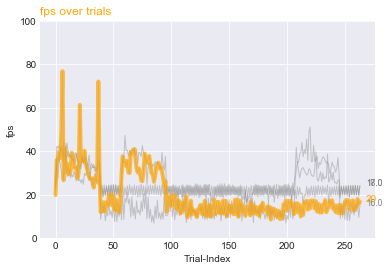

In [43]:
spaghettiPlot(grouped, "fps over trials", "fps", 20)

## 3.2 Does the accuracy improve during calibration?

Ceil deviation to window_height_max

In [46]:
data_et.loc[data_et["offset"]>data_et["window_height"], "offset"] = data_et["window_height"]
print("Max deviation: " + str(data_et["offset"].max()))
print("Min deviation: " + str(data_et["offset"].min()))

Max deviation: 1152.0
Min deviation: 0.0


Plot deviation over calibration trials

In [49]:
data_et.columns

Index(['run_id', 'subject', 'chinFirst', 'trial_type', 'trial_index', 'index',
       'task_nr', 'chin', 'x_pos', 'y_pos', 'px', 'py', 'option_topLeft',
       'option_topRight', 'option_bottomLeft', 'option_bottomRight', 'x', 'y',
       't_wg', 't_task', 'click', 'key_press', 'fps', 'devPercAvg',
       'window_width', 'window_height', 'distance_new', 'distance_perc'],
      dtype='object')

In [50]:
data_et_cal1 = pd.DataFrame(
                            data_et[((data_et["x"]>-1) & 
                                     (data_et["y"]>-1) & 
                                     (data_et['trial_type']== "eyetracking-calibration") &
                                     (data_et['index'] < 98) &  # task_nr == 0 
                                     (pd.notna(data_et["offset_perc"]))
                                    )] \
                            .groupby(["run_id", "index", "trial_type"]) \
                            ["offset_perc"].mean()  
                        ).reset_index()
data_et_cal1.run_id.unique()

array([16., 17., 18., 20.])

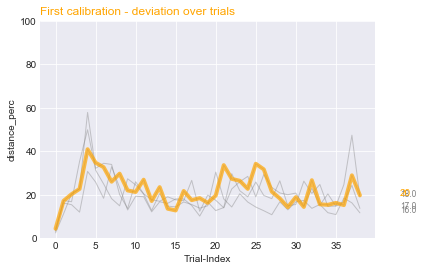

In [51]:
spaghettiPlot(data_et_cal1, "First calibration - deviation over trials", "offset_perc", 20)

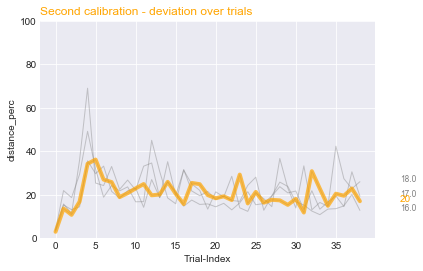

In [52]:
data_et_cal2 = pd.DataFrame(
                            data_et[((data_et["x"]>-1) & 
                                     (data_et["y"]>-1) & 
                                     (data_et['trial_type']== "eyetracking-calibration") &
                                     (data_et['index']> 97) & # task_nr > 0
                                     (pd.notna(data_et["offset_perc"]))
                                    )] \
                            .groupby(["run_id", "index", "trial_type"]) \
                            ["offset_perc"].mean()  
                        ).reset_index()
spaghettiPlot(data_et_cal2, "Second calibration - deviation over trials", "offset_perc", 20)

# 4 Can we replicate decision making findings? 

## 4.1 Can we predict choice task by how often the people look top?

### 3.4.2 Logistic Model

Statsmodel

Sklearn-package

In [53]:
model = LogisticRegression(solver='liblinear', random_state=0)
data_et_choice["run_id"] = data_et_choice["run_id"].astype('category')
X = data_et_choice[["run_id", "choiceNr", "look_top"]]
y = data_et_choice["chose_top"]
model.fit(X, y)
coeffs = pd.Series(model.coef_[0], index=X.columns.values)
print("Intercept   " + str(round(model.intercept_[0], 6)))
print(coeffs.sort_values(ascending = False))

Intercept   0.254279
look_top    0.381664
choiceNr   -0.004856
run_id     -0.015233
dtype: float64


# 4 Hypotheses
[Back to Navigation](#Navigation)

## 4.1 H1-H4

To answer hypothesis 1, and 4, we will predict the subject’s choices from the intertemporal choice task with a mixed-effects logistic regression, with the option index (H1), the attribute index (H2), the Payne Index (H3), and the trial number as fixed effects and the subject as the random effect. 

### 4.1.1 Requirements

In [54]:
X = data_trial_choice[["run_id", "choiceNr", "optionIndex", 'attributeIndex', 'payneIndex']]
y = 1-data_trial_choice[["choseLL"]]  

In [58]:
def noMissingValues(data):
    null_data = X.loc[X.isnull().any(axis=1), :]
    if len(null_data) > 0:
        print('There are some missing data. Look here: \n \n')
        print(null_data)
        return(False)
    else:
        print('No missing values!')
        return(True)

In [56]:
noMissingValues(X)

     run_id  choiceNr  optionIndex  attributeIndex  payneIndex
86       17        12     1.000000        1.000000         NaN
87       17        13    -0.904762        0.904762         NaN
101      17        27    -1.000000        1.000000         NaN
104      17        30    -1.000000        1.000000         NaN
118      17        44    -1.000000        1.000000         NaN
130      17        56     1.000000        1.000000         NaN
131      17        57    -1.000000        1.000000         NaN
136      17        62     1.000000        1.000000         NaN
137      17        63    -1.000000        1.000000         NaN
138      17        64    -1.000000        1.000000         NaN
139      17        65     1.000000        1.000000         NaN
140      17        66    -1.000000        1.000000         NaN
141      17        67     1.000000        1.000000         NaN
142      17        68     1.000000        1.000000         NaN
153      18         4    -1.000000        1.000000     

False

In [80]:
# def excludeNAN(data):
#     index_null_data = data.loc[data.isnull().any(axis=1), :].index
#     data_output = data.drop(index_null_data).reset_index()
#     return(data_output)

### 4.1.2 Model

In [82]:
log_reg = sm.Logit(y, X, missing='drop').fit() 
print(log_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.544613
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                choseLL   No. Observations:                  280
Model:                          Logit   Df Residuals:                      275
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:                  0.1852
Time:                        11:15:44   Log-Likelihood:                -152.49
converged:                       True   LL-Null:                       -187.16
Covariance Type:            nonrobust   LLR p-value:                 3.134e-14
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
run_id             0.0515      0.017      2.997      0.003       0.018       0.085
choiceNr         

## 4.2 H3 clustering

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_trial_choice.loc[:, [
                                                                  'trans_diff_0',
                                                                  'trans_diff_1',
                                                                  'trans_diff_2',
                                                                  'trans_diff_3',
                                                                  'trans_diff_4',
                                                                  'trans_diff_6',
                                                                  'trans_diff_7',
                                                                 ]
                                                             ]
                                      )

In [85]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [86]:
output = []
for n_cluster in range(2, 5):
    data_trial_choice['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_trial_choice[["run_id", "choiceNr", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_trial_choice[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

Optimization terminated successfully.
         Current function value: 0.597284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.602432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589976
         Iterations 6


,BIC,AIC
n_clusters,,
2,381.185235,366.370106
3,384.274057,369.458927
4,376.800782,361.985652


## H5 - H6
[Back to Navigation](#Navigation)

For hypotheses 5 and 6, we will use three mixed-effects general linear models to predict accuracy, precision and frame rate with the chin-rest condition, visual aid variables, trial number (fixed effects) and the subject (random-effect). 

### Descriptives

Separate Dataset

In [98]:
grouped_mean = data_et_fixTask.groupby(["run_id", "chin"])['offset', "x", "y"].mean() \
    .reset_index() \
    .rename(columns={"offset": "offset_mean",
                     "x": "x_mean",
                     "y": "y_mean"})
grouped_mean["offset_mean"] = grouped_mean['offset_mean'] / 100

grouped_var = data_et_fixTask.groupby(["run_id", "chin"])["x", "y"].std() \
    .reset_index() \
    .rename(columns={"offset_perc": "accuracy",
                     "x": "x_std",
                     "y": "y_std"})

grouped_height = data_et_fixTask.groupby(["run_id", "chin"])["window_height"].max() \
    .reset_index()
grouped_merged = grouped_mean.merge(grouped_var, on=['run_id', 'chin']) \
    .merge(grouped_height, on=['run_id', 'chin']) \
    .rename(columns={"window_height": "height"})
summary_fixTask = grouped_merged

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [99]:
summary_fixTask['x_std_rel'] = summary_fixTask.x_std / summary_fixTask.height
summary_fixTask['y_std_rel'] = summary_fixTask.y_std / summary_fixTask.height
summary_fixTask

,run_id,chin,offset,x_mean,y_mean,x_std,y_std,height,x_std_rel,y_std_rel
0,16.0,0.0,1.916012,631.109069,388.243873,218.775918,116.803114,720.0,0.303855,0.162227
1,16.0,1.0,1.441557,695.400534,359.411215,258.596582,121.236396,720.0,0.359162,0.168384
2,17.0,0.0,1.689543,664.384501,423.815946,278.391954,105.773172,720.0,0.386655,0.146907
3,17.0,1.0,1.746308,642.416541,392.445865,221.539068,118.348450,720.0,0.307693,0.164373
4,18.0,0.0,2.409983,675.731377,298.048157,207.735777,127.892436,720.0,0.288522,0.177628
5,18.0,1.0,2.396225,523.447964,369.107843,238.175667,102.722890,720.0,0.330800,0.142671
6,20.0,0.0,2.595306,1047.682752,606.607803,317.997041,190.848223,1152.0,0.276039,0.165667
7,20.0,1.0,3.439579,1210.520161,644.182460,323.569801,204.115112,1152.0,0.280877,0.177183


In [106]:
accuracy_chin = summary_fixTask.loc[
    (summary_fixTask.chin == 1), ['run_id', 'offset_mean', 'x_std_rel', 'y_std_rel']] \
    .rename(columns={"offset_mean": "offset_mean_chin",
                     "x_std_rel": "x_std_rel_chin",
                     "y_std_rel": 'y_std_rel_chin'                  
                    })
accuracy_noChin = summary_fixTask.loc[
    (summary_fixTask.chin == 0), ['run_id', 'offset_mean', 'x_std_rel', 'y_std_rel']] \
    .rename(columns={"offset_mean": "offset_mean_noChin",
                     "x_std_rel": "x_std_rel_noChin",
                     "y_std_rel": 'y_std_rel_noChin'})
withinDifference_fixTask = accuracy_chin.merge(accuracy_noChin, on='run_id', how='left')
withinDifference_fixTask["deltaOffset"] = withinDifference_fixTask['offset_mean_chin'] - \
    withinDifference_fixTask['offset_mean_noChin']
withinDifference_fixTask["deltaPrecision_x"] = withinDifference_fixTask['x_std_rel_chin'] - \
    withinDifference_fixTask['x_std_rel_noChin']
withinDifference_fixTask["deltaPrecision_y"] = withinDifference_fixTask['y_std_rel_chin'] - \
    withinDifference_fixTask['y_std_rel_noChin']
withinDifference_fixTask

,run_id,offset_chin,x_std_rel_chin,y_std_rel_chin,offset_noChin,x_std_rel_noChin,y_std_rel_noChin,deltaOffset,deltaPrecision_x,deltaPrecision_y
0,16.0,1.441557,0.359162,0.168384,1.916012,0.303855,0.162227,-0.474454,0.055306,0.006157
1,17.0,1.746308,0.307693,0.164373,1.689543,0.386655,0.146907,0.056766,-0.078962,0.017466
2,18.0,2.396225,0.330800,0.142671,2.409983,0.288522,0.177628,-0.013758,0.042278,-0.034958
3,20.0,3.439579,0.280877,0.177183,2.595306,0.276039,0.165667,0.844273,0.004837,0.011516


### Model

In [195]:
data_subject.columns

Index(['run_id', 'subject', 'chinFirst', 'user_agent', 'device', 'browser',
       'browser_version', 'platform', 'platform_version', 'prolificID', 'age',
       'gender', 'ethnic', 'sight', 'glasses', 'income', 'incomeCurrency',
       'degree', 'eyeshadow', 'masquara', 'eyeliner', 'browliner', 'natLight',
       'artLight', 'distance', 'unit', 'ruler', 'vertPosition', 'triedChin',
       'keptHead', 'optionalNote'],
      dtype='object')

In [273]:
data_trial_fixTask.columns

Index(['run_id', 'subject', 'trial_index', 'task_nr', 'x_pos', 'y_pos', 'px',
       'py', 'x', 'y', 't_task', 'offset', 'offset_perc', 'chinFirst', 'chin',
       'time_elapsed', 'trial_duration', 'recorded_at', 'devAvg', 'devPercAvg',
       'window_width', 'window_height', 't_startTrial', 't_trialDuration',
       'fixation_nr'],
      dtype='object')

In [ ]:
data_h5h6 = data_trial_fixTask.loc[:, 
                                       [
                                           'run_id', 'subject', 
                                           'chinFirst', 'chin', #Experimental condition
                                           'x_pos', 'y_pos', 'fixation_nr', 
                                           # 'offset', # Prediction
                                           'offset_perc', 
                                           'chin',                                        
                                       ]
                                  ]
       .merge(data_subject)

In [109]:
import statsmodels.api as sm
import statsmodels.formula.api as smf



Index(['run_id', 'subject', 'chinFirst', 'chin', 'stimulus', 'x_pos', 'y_pos',
       'task_nr', 'trial_type', 'trial_index', 'time_elapsed',
       'trial_duration', 'recorded_at', 'rt', 'responses', 'key_press', 'fps',
       'devAvg', 'devPercAvg', 'option_topLeft', 'option_bottomLeft',
       'option_topRight', 'option_bottomRight', 'window_width',
       'window_height', 't_startTrial', 't_trialDuration', 'tooQuick'],
      dtype='object')

In [108]:
model = smf.mixedlm("offset ~ Time", data_trial, groups=data_["Pig"])
model_fit = md.fit()
print(mdf.summary())

NameError: name 'data' is not defined

[Back to Navigation](#Navigation)